# Mullan Pass (KMLP)

In [1]:
import archive
from project_utilities import normalize_var, get_monthly_average_vpd

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from datetime import datetime

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.5


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
arch = archive.Archive()
start = datetime(1948, 1, 1)
end = datetime(2021, 12, 31)

Archive root is /home/ryan/programming/bayes-trends/default_archive
Connected to /home/ryan/programming/bayes-trends/default_archive/obs.db


## June through October Average Vapor Pressure Deficit

I use June through October for a couple reasons. First, some have claimed that fire season is getting longer, and if that is the case it may show up as a higher VPD in the shoulder seasons of June and October. This period also covers all of the fire season.

In [4]:
# Load the data
data = get_monthly_average_vpd(arch, 'kmlp', months=(6, 7, 8, 9, 10), starting=start, ending=end)
df = pd.DataFrame(data, columns=["year", "avg_vpd"])

x_norm, x_denorm = normalize_var(df, 'year', 'x_obs')
y_norm, y_denorm = normalize_var(df, 'avg_vpd', 'y_obs')

df


year offset = 1996.2333333333333 scale = 26.07771321333183


avg_vpd offset = 6.777667799737558 scale = 1.1391758241180874



,year,avg_vpd,x_obs,y_obs
0,1948,4.739392,-1.849600,-1.789255
1,1949,6.550098,-1.811253,-0.199767
2,1950,5.415685,-1.772906,-1.195586
3,1951,6.053258,-1.734559,-0.635907
4,1952,6.924309,-1.696212,0.128725
5,1953,6.672871,-1.657865,-0.091994
6,1954,4.693420,-1.619518,-1.829610
7,1999,5.991873,0.106093,-0.689792
8,2000,6.329215,0.144440,-0.393665
9,2001,7.250994,0.182787,0.415499


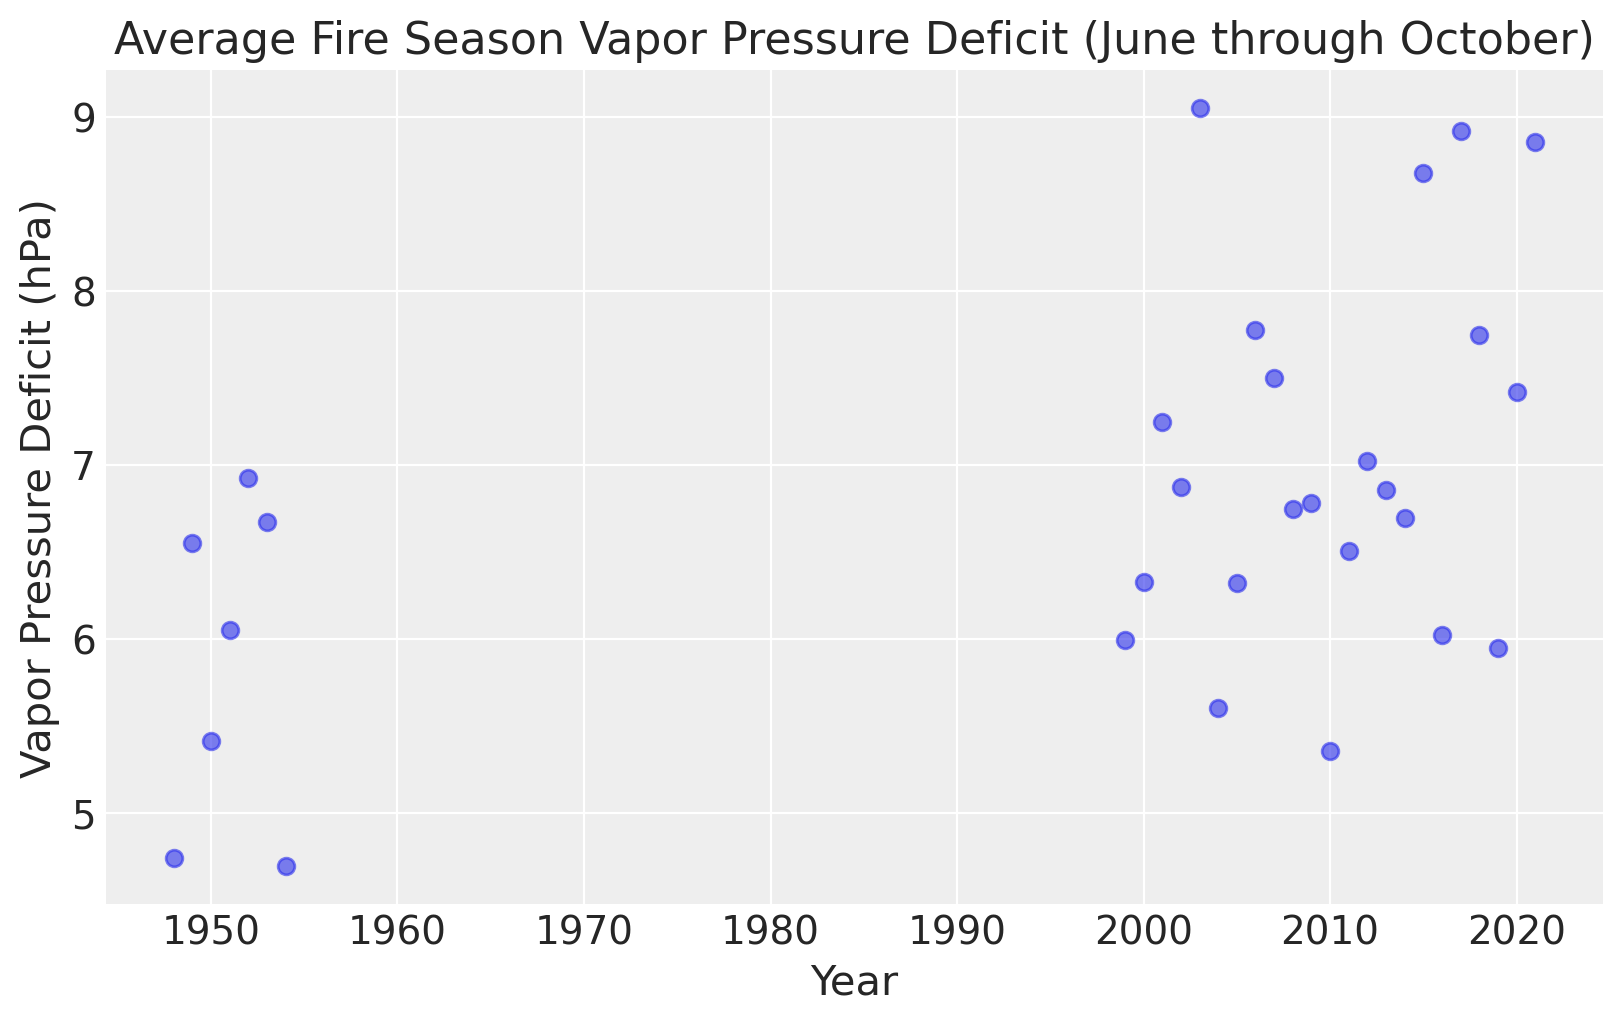

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,5));
ax.scatter(x_denorm(df['x_obs']), y_denorm(df['y_obs']), alpha=0.6);
ax.set_ylabel('Vapor Pressure Deficit (hPa)');
ax.set_xlabel('Year');
ax.set_title('Average Fire Season Vapor Pressure Deficit (June through October)');

In [6]:
x_future = x_norm(xr.DataArray(range(2022,2036)))

linear_model = pm.Model()

with linear_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    nu = pm.Exponential('nu', lam=1)
    
    # Set predictors as shared variable to change them fo PPC
    pred = pm.MutableData("pred", df['x_obs'])
    mu = alpha + beta * pred
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['y_obs'])

    idata = pm.sample(2000, tune=2000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


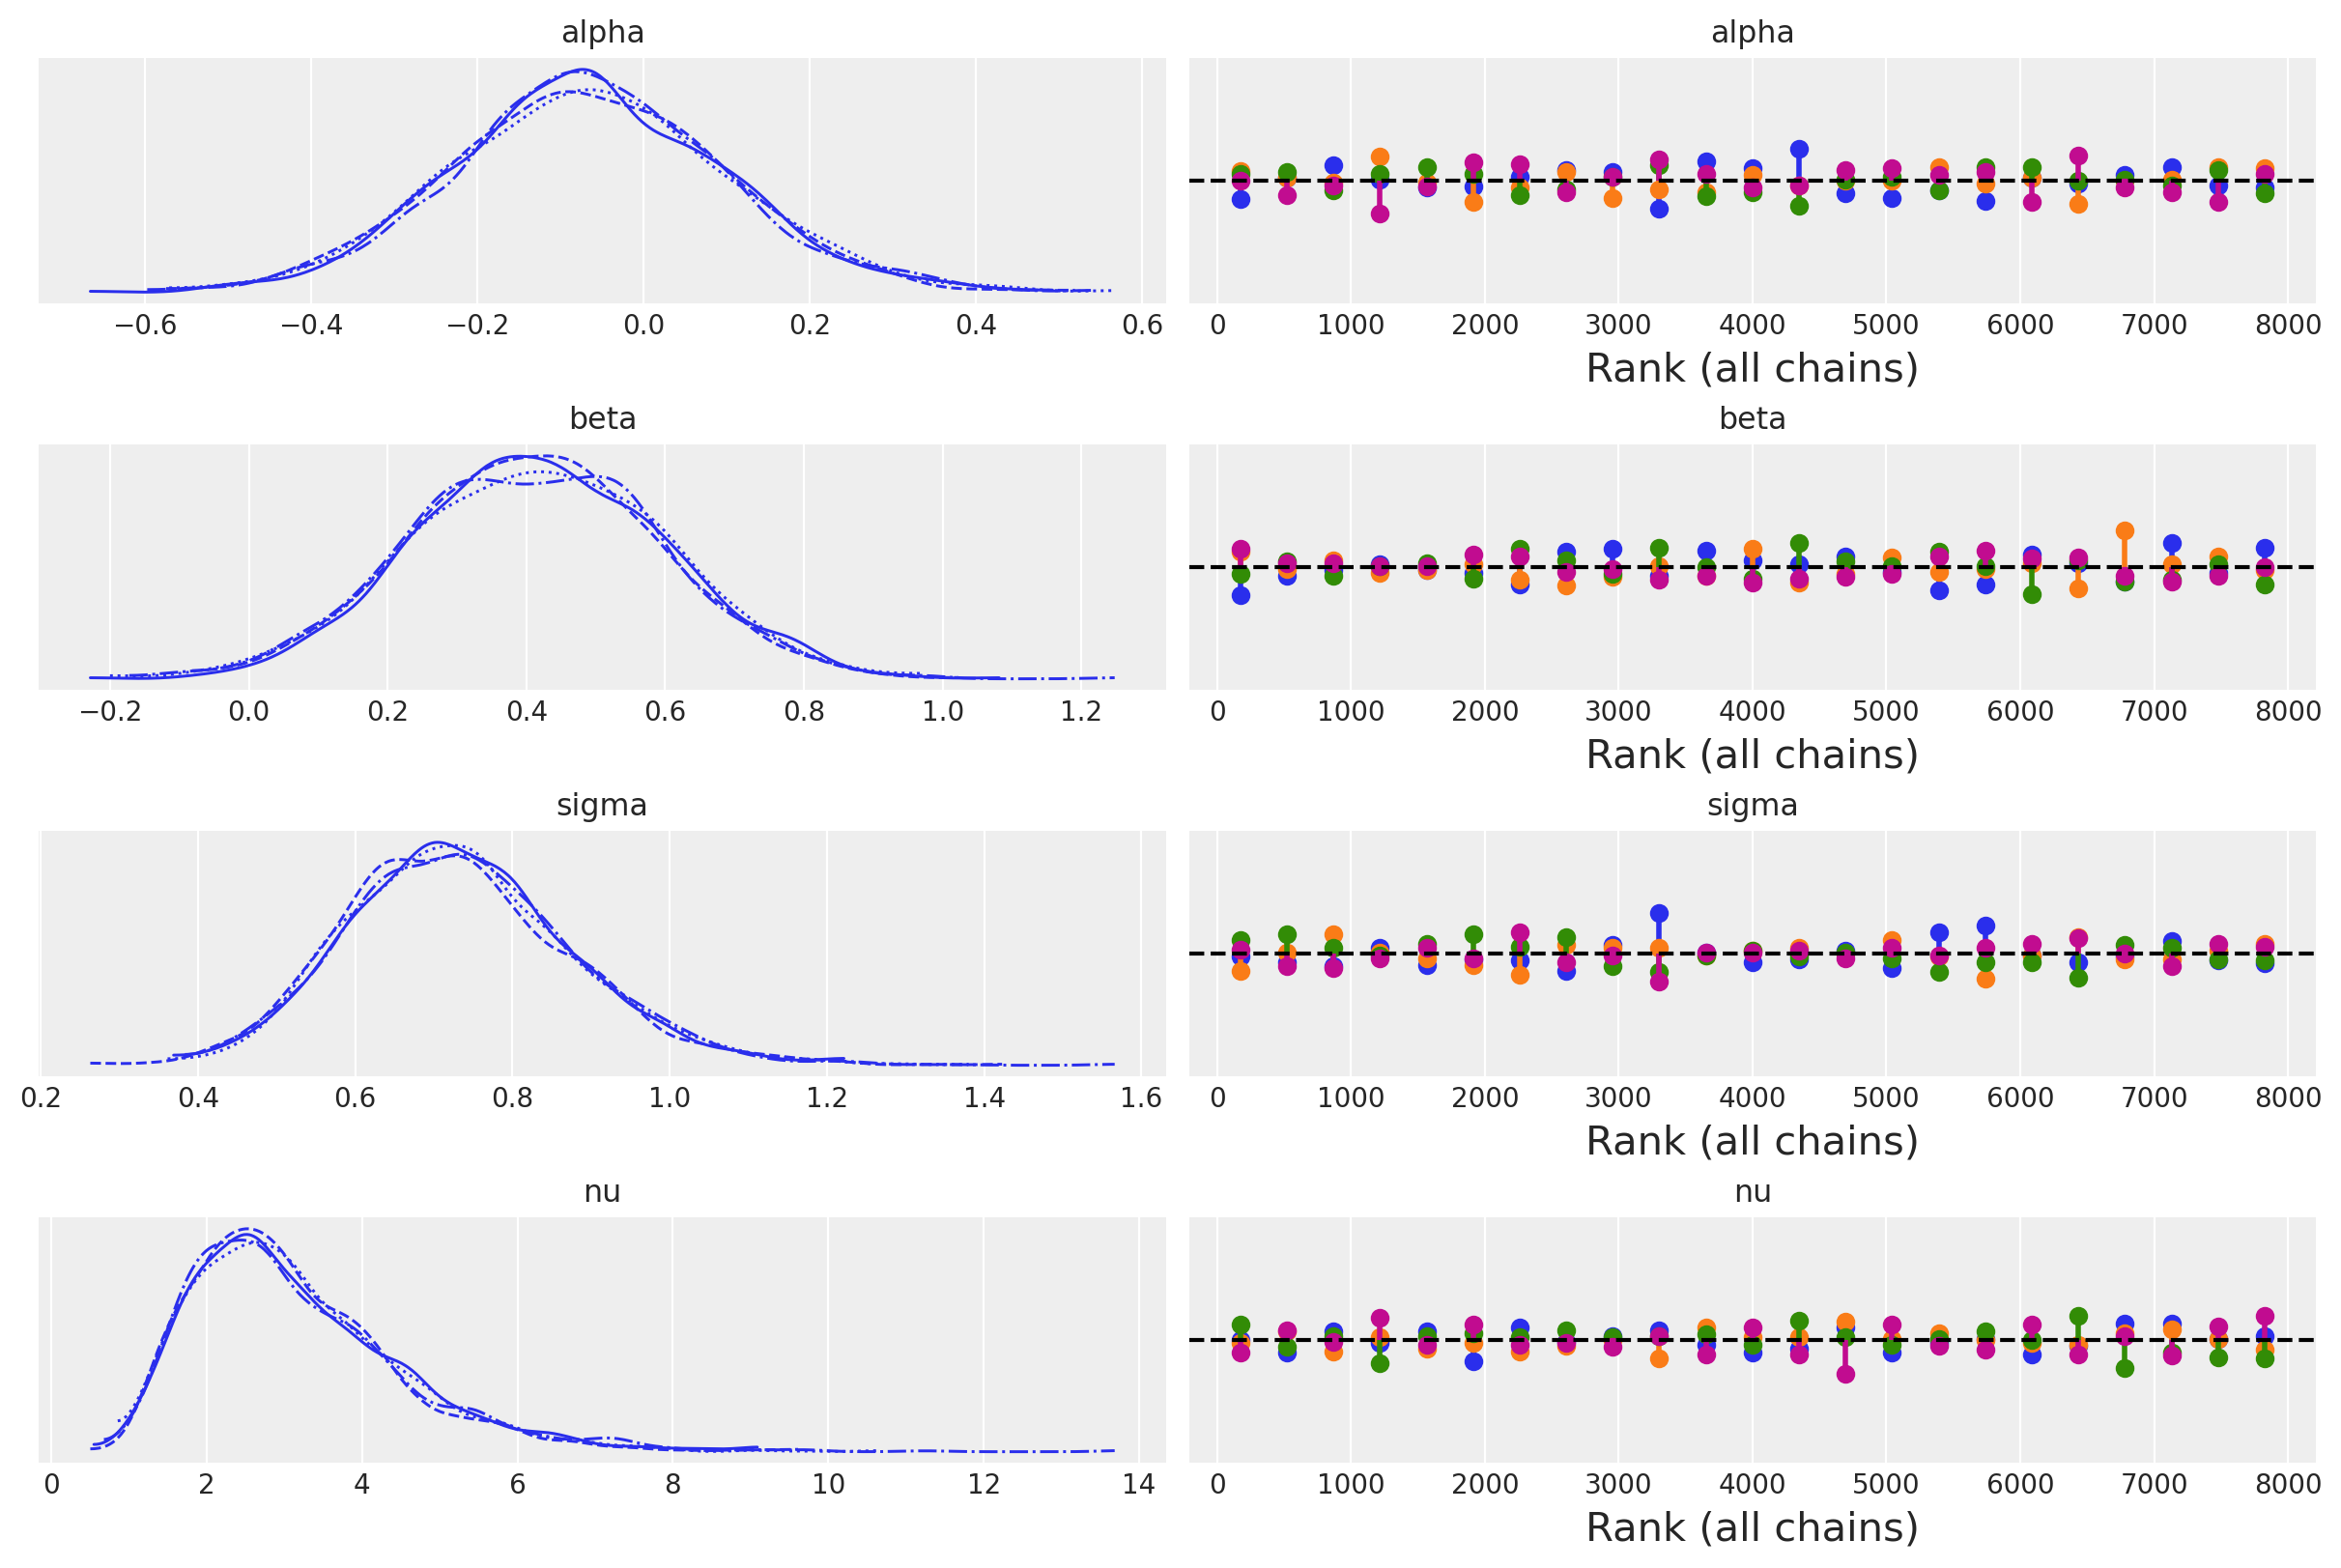

In [7]:
az.plot_trace(idata, kind='rank_vlines');

In [8]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.066,0.165,-0.386,0.241,0.002,0.002,10077.039,6264.915,1.000
beta,0.415,0.181,0.066,0.742,0.002,0.001,9478.251,6052.941,1.002
sigma,0.732,0.144,0.466,0.999,0.002,0.001,5851.710,5076.151,1.000
nu,3.141,1.354,1.125,5.696,0.016,0.011,6870.142,5940.605,1.000


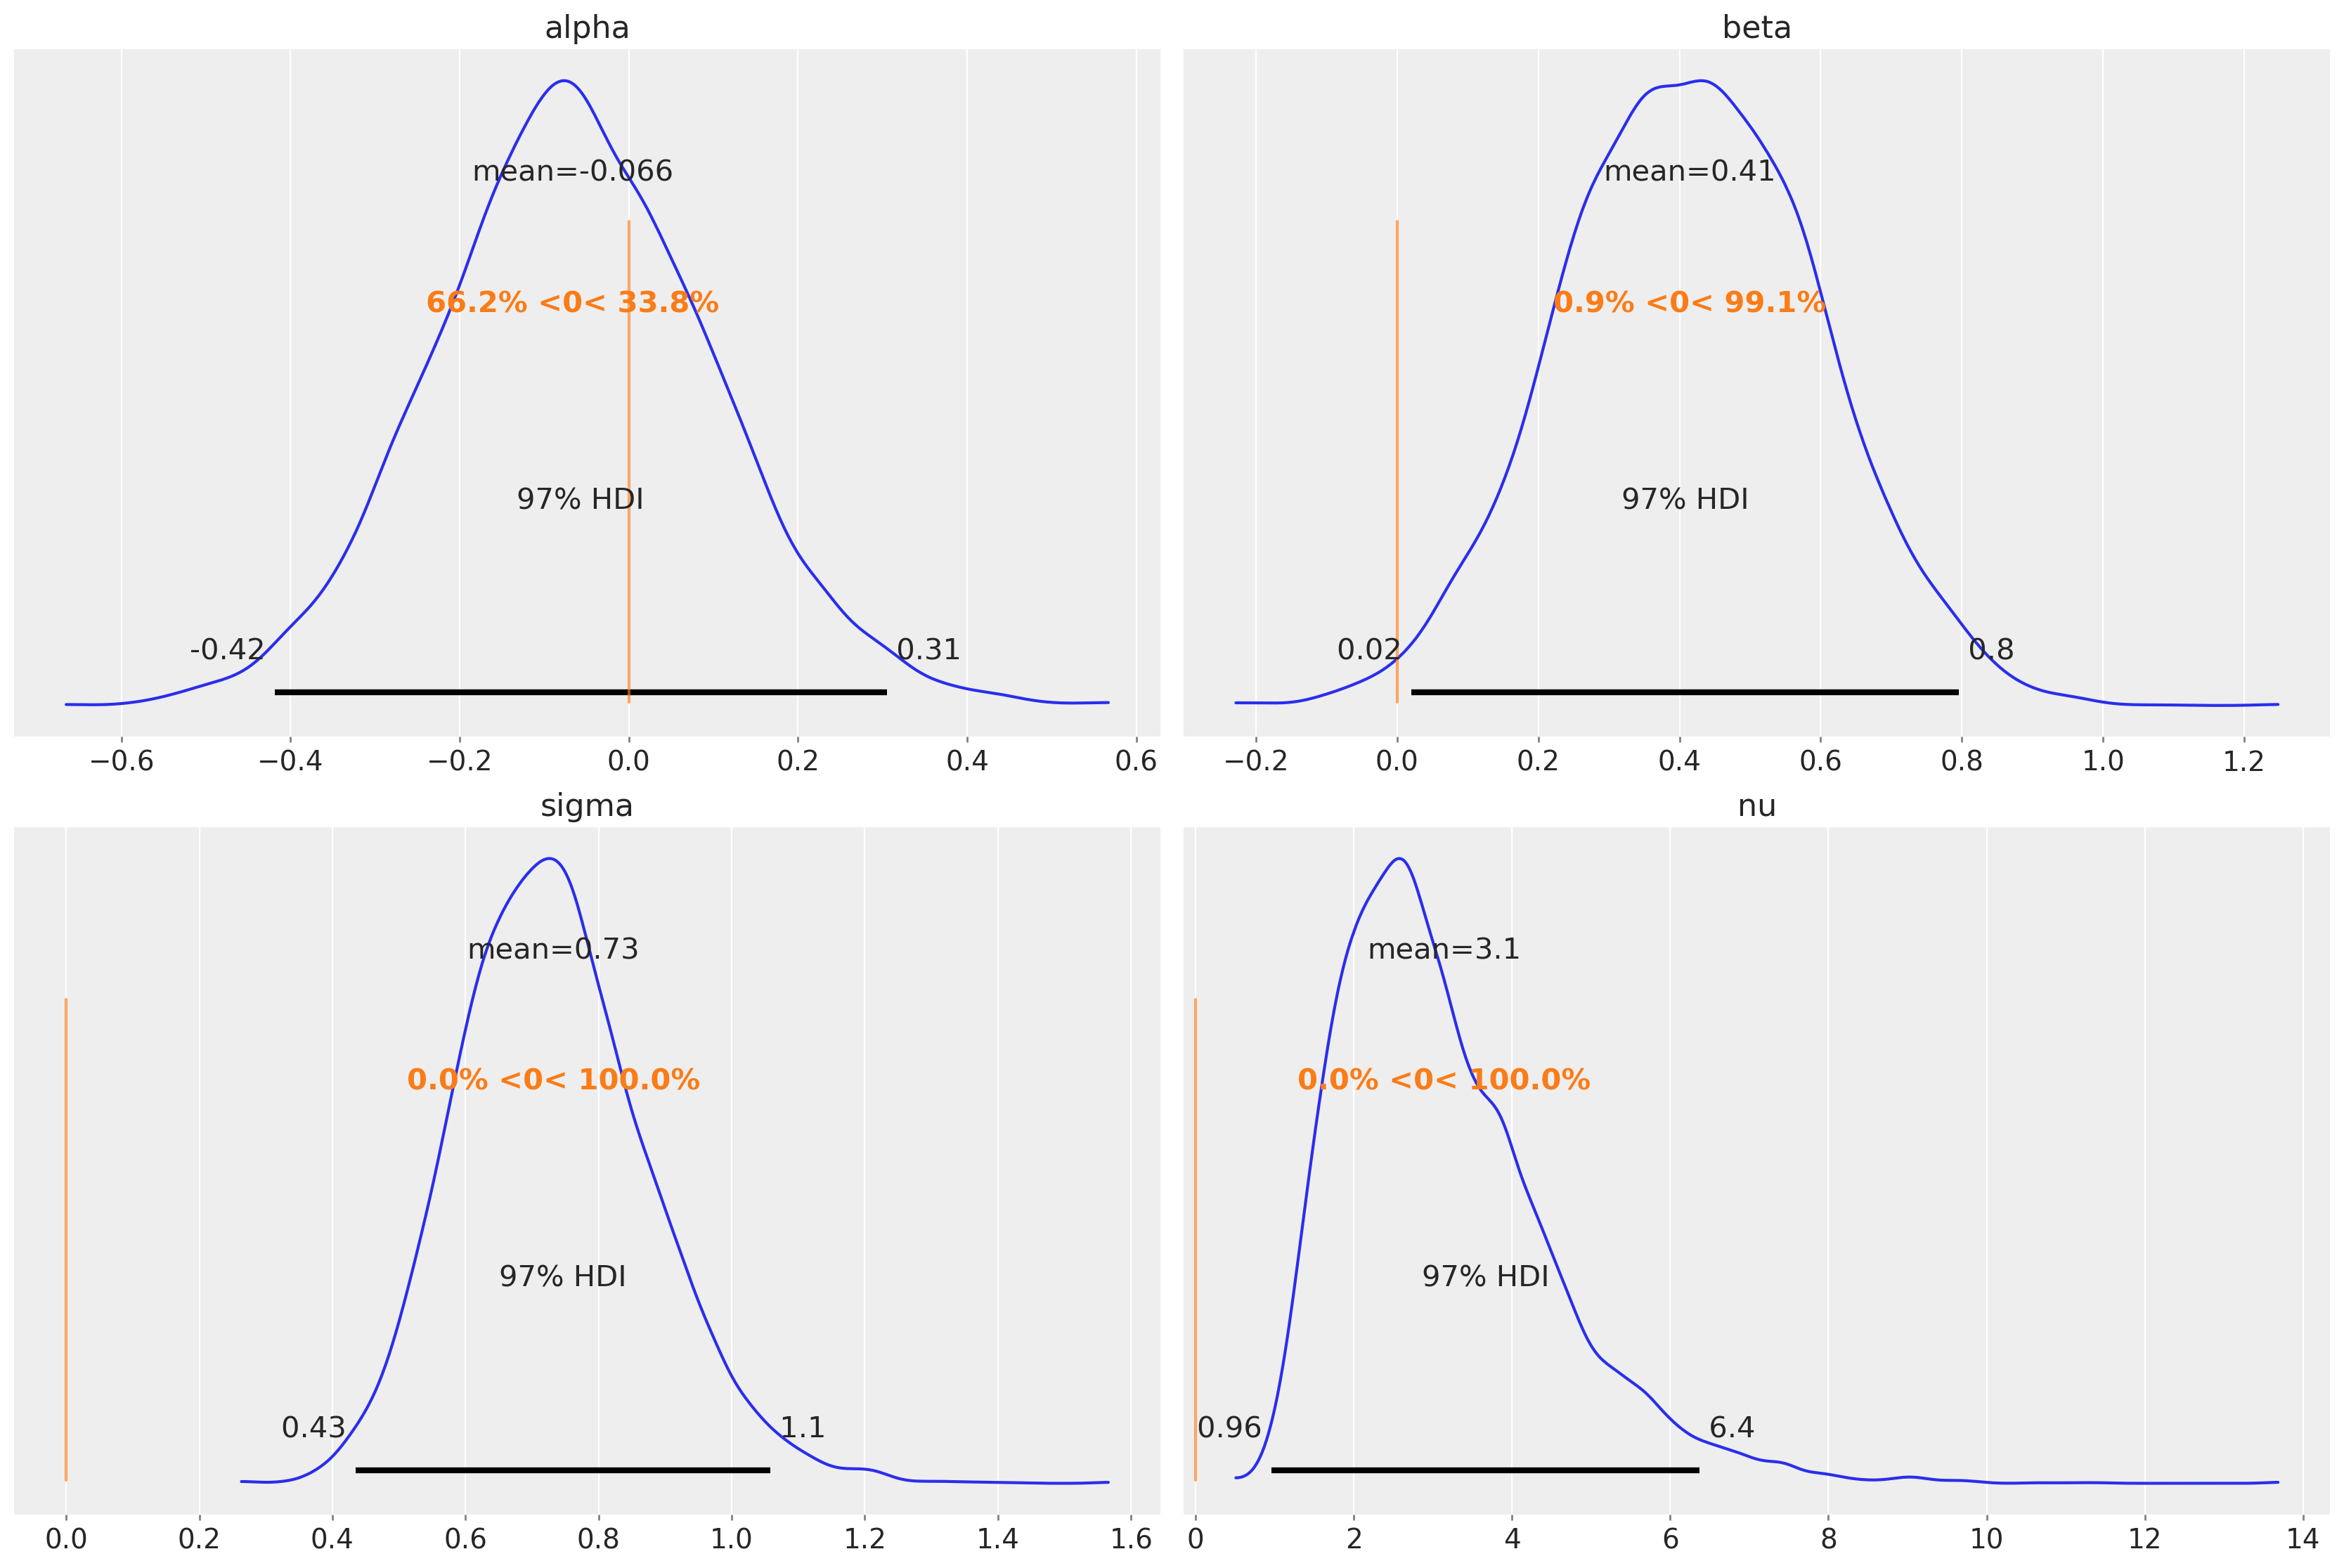

In [9]:
az.plot_posterior(idata, grid=(2,2), hdi_prob=0.97, ref_val=0.0);

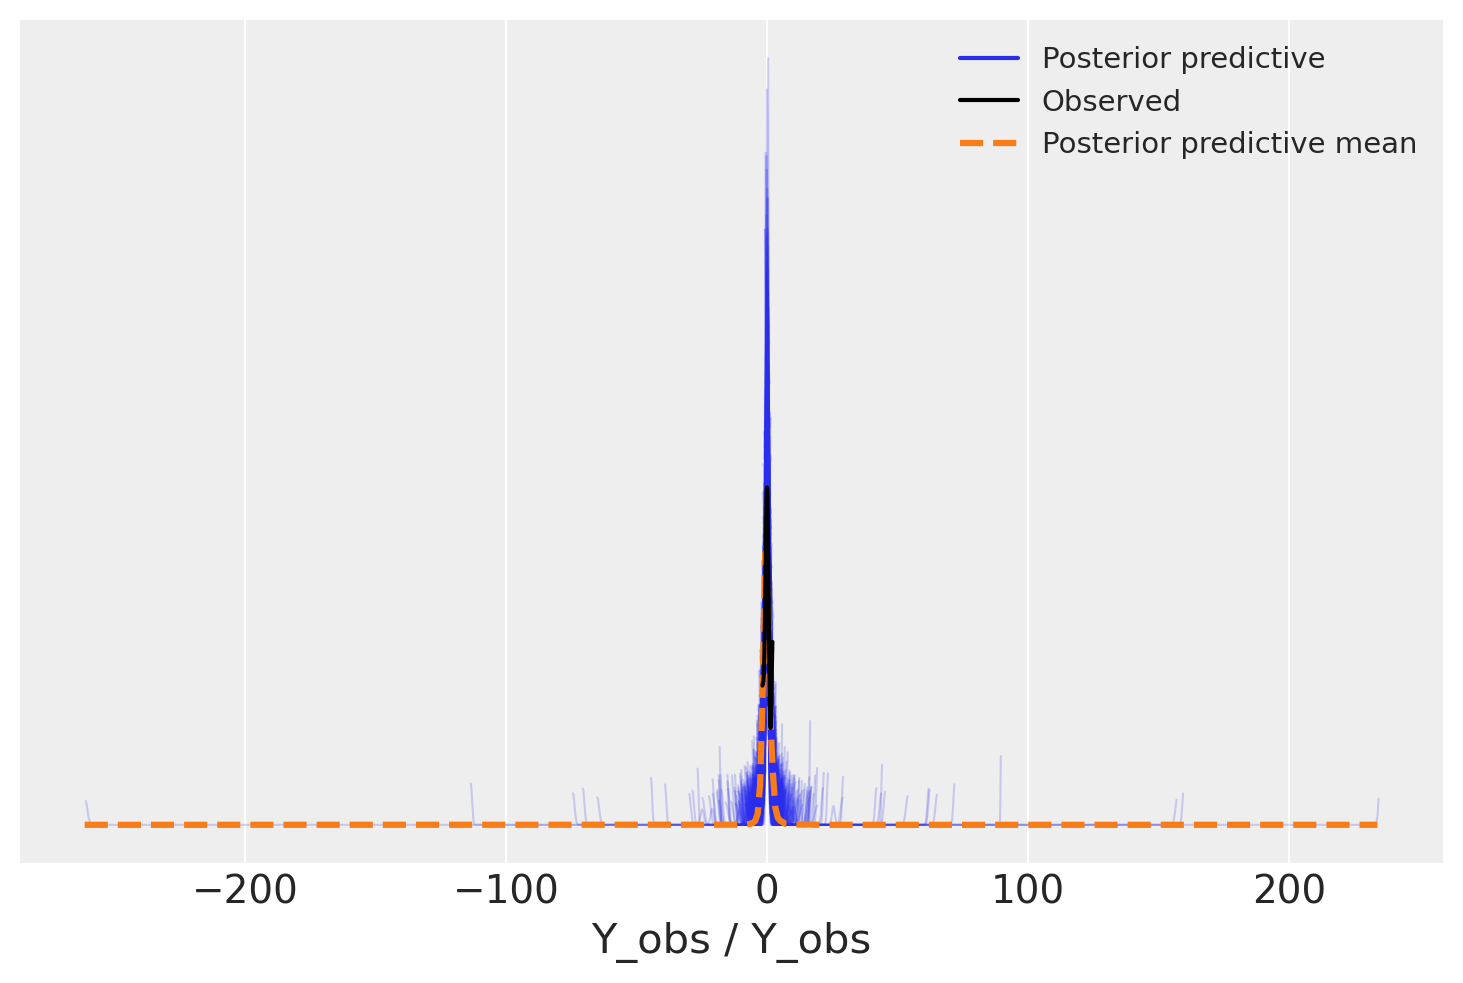

In [10]:
with linear_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True);
az.plot_ppc(idata, num_pp_samples=1000);

In [11]:
with linear_model:
    pm.set_data({"pred": x_future})
    idata=pm.sample_posterior_predictive(
        idata,
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )
    
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

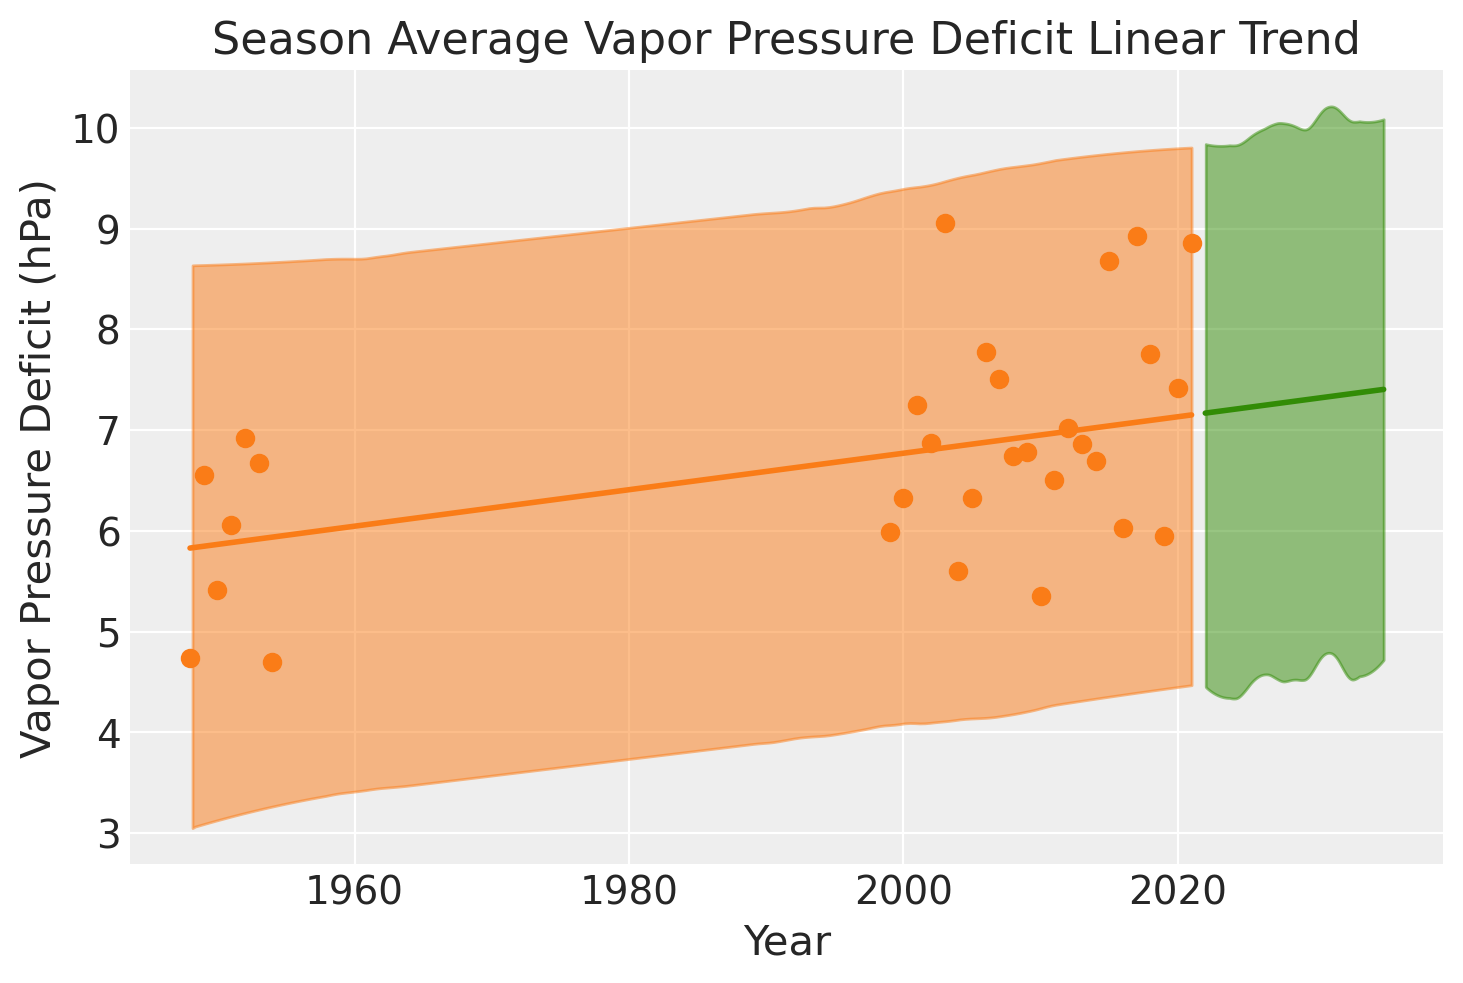

In [12]:
post = idata.posterior
mu_pp = post['alpha'] + post['beta'] * xr.DataArray(df['x_obs'])
mu_pp_future = post['alpha'] + post['beta'] * x_future

_, ax  = plt.subplots()

ax.plot(
    x_denorm(df['x_obs']), 
    y_denorm(mu_pp.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C1', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(df['x_obs']),
    y_denorm(idata.posterior_predictive['Y_obs']),
    color='C1',
);

ax.scatter(
    x_denorm(df['x_obs']),
    y_denorm(df['y_obs']),
    color='C1'
);

ax.plot(
    x_denorm(x_future), 
    y_denorm(mu_pp_future.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C2', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(x_future),
    y_denorm(idata.predictions['Y_obs']),
    color='C2'
);

ax.set_title("Season Average Vapor Pressure Deficit Linear Trend");
ax.set_ylabel("Vapor Pressure Deficit (hPa)");
ax.set_xlabel("Year");